# Clothes detection with

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">


# Import detectron2 utils

In [1]:
import torch
assert torch.__version__.startswith("1.8")
print(torch.__version__, torch.cuda.is_available())

1.8.1+cu102 True


In [2]:
# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import os
import cv2
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on DeepFashion2 dataset

### Empty cache

In [3]:
torch.cuda.empty_cache()



### Prepare the dataset

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train_dataset", {}, "./dataset/detectron_annos/train_annos_all.json", "./dataset/train/image/")
register_coco_instances("validation_dataset", {}, "./dataset/detectron_annos/validation_annos_5000.json", "./dataset/validation/image")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [5]:
dataset_dicts = DatasetCatalog.get("train_dataset")
clothes_metadata = MetadataCatalog.get("train_dataset")

[06/27 15:45:28 d2.data.datasets.coco]: Loading ./dataset/detectron_annos/train_annos_all.json takes 44.75 seconds.
[06/27 15:45:28 d2.data.datasets.coco]: Loaded 191961 images in COCO format from ./dataset/detectron_annos/train_annos_all.json


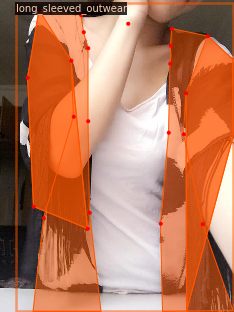

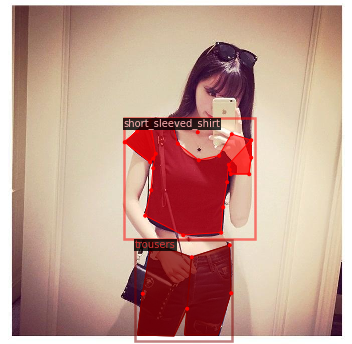

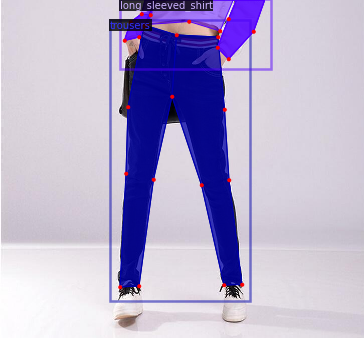

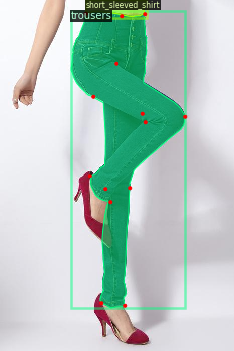

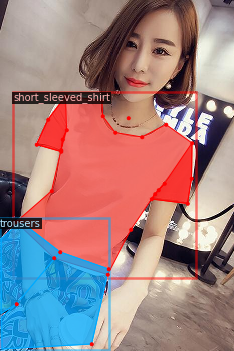

In [6]:
from PIL import Image

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=clothes_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    img_pil = Image.fromarray(out.get_image(), 'RGB')
    display(img_pil)

## Train  
### training config

In [9]:
from clothes_trainer import ClothesTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train_dataset",)
cfg.DATASETS.TEST = ('validation_dataset',)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 280000
cfg.SOLVER.STEPS = (210000, 250000)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13

cfg.SOLVER.CHECKPOINT_PERIOD = 10000
cfg.TEST.EVAL_PERIOD = 10000

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = ClothesTrainer(cfg)

[06/27 15:46:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[06/27 15:46:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [<detectron2.data.transforms.augmentation_impl.RandomApply object at 0x7fe7817a4e50>, RandomFlip(prob=0.5), <detectron2.data.transforms.augmentation_impl.RandomApply object at 0x7fe54bdddd10>, <detectron2.data.transforms.augmentation_impl.RandomApply object at 0x7fe54bdddd50>, <detectron2.data.transforms.augmentation_impl.RandomApply object at 0x7fe54bdddb90>, <detectron2.data.transforms.augmentation_impl.RandomApply object at 0x7fe54bdddad0>, <detectron2.data.transforms.augmentation_impl.RandomApply object at 0x7fe54bdddb50>]
[06/27 15:46:44 d2.data.datasets.coco]: Loading ./dataset/detectron_annos/train_annos_all.json takes 39.84 seconds.
[06/27 15:46:45 d2.data.datasets.coco]: Loaded 191961 images in COCO format from ./dataset/detectron_annos/train_annos_all.json
[06/27 15:47:16 d2.data.build]: Removed 0 images with no usable annotations. 191961 images left.
[06/27 15:47:26 d2.data.build]: Distr

### show augmented images

In [10]:
augmentation_data_loader = trainer.build_train_loader(cfg)

[06/27 15:47:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [<detectron2.data.transforms.augmentation_impl.RandomApply object at 0x7fe51c06c5d0>, RandomFlip(prob=0.5), <detectron2.data.transforms.augmentation_impl.RandomApply object at 0x7fe51c06c590>, <detectron2.data.transforms.augmentation_impl.RandomApply object at 0x7fe51c06c490>, <detectron2.data.transforms.augmentation_impl.RandomApply object at 0x7fe51c06c250>, <detectron2.data.transforms.augmentation_impl.RandomApply object at 0x7fe51c06c390>, <detectron2.data.transforms.augmentation_impl.RandomApply object at 0x7fe51c06c210>]
[06/27 15:49:58 d2.data.datasets.coco]: Loading ./dataset/detectron_annos/train_annos_all.json takes 120.60 seconds.
[06/27 15:49:59 d2.data.datasets.coco]: Loaded 191961 images in COCO format from ./dataset/detectron_annos/train_annos_all.json
[06/27 15:50:31 d2.data.build]: Removed 0 images with no usable annotations. 191961 images left.
[06/27 15:50:41 d2.data.build]: Usin

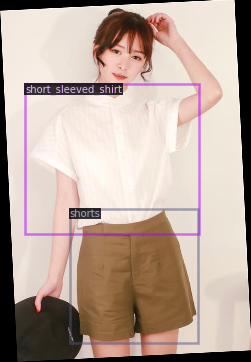

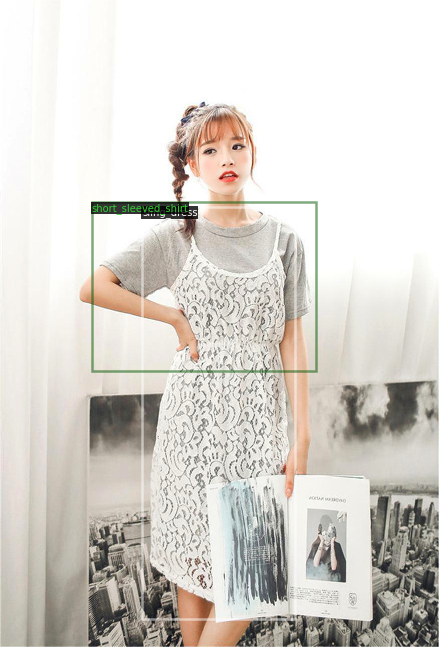

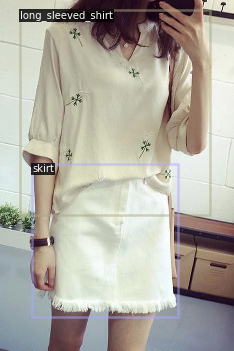

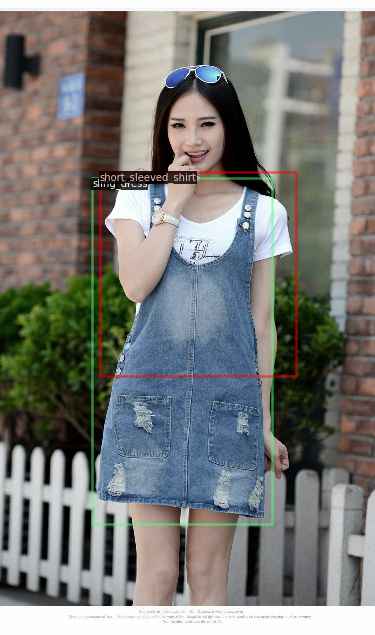

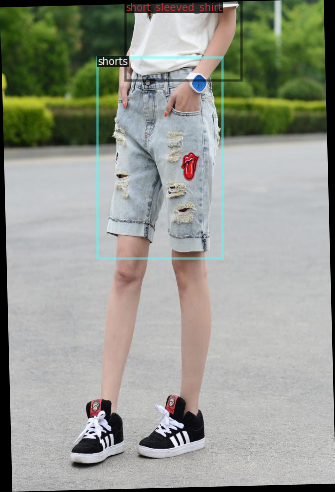

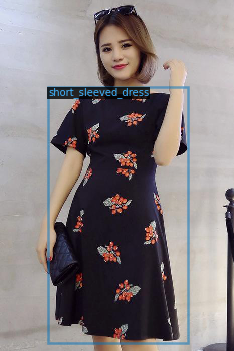

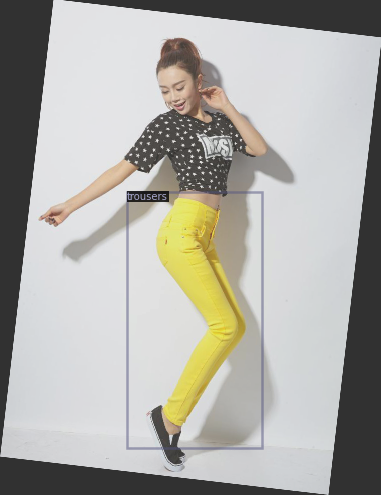

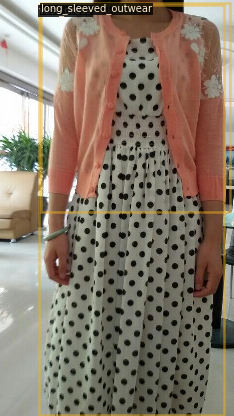

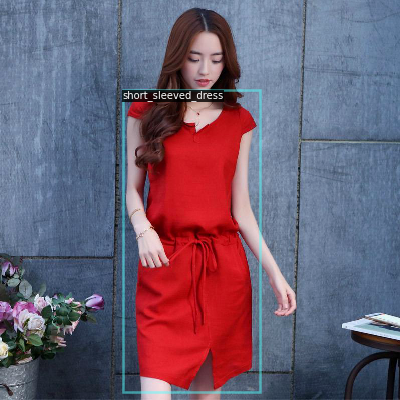

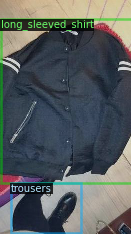

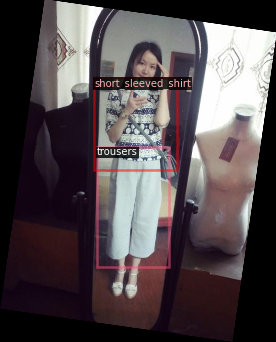

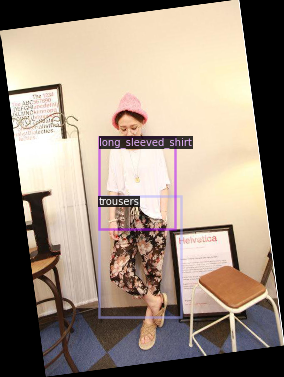

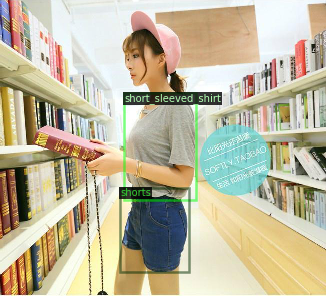

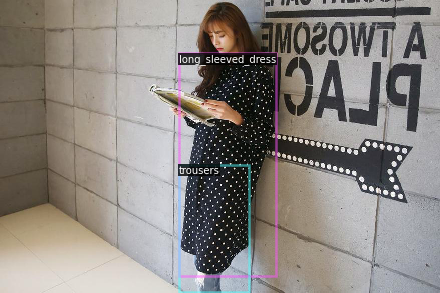

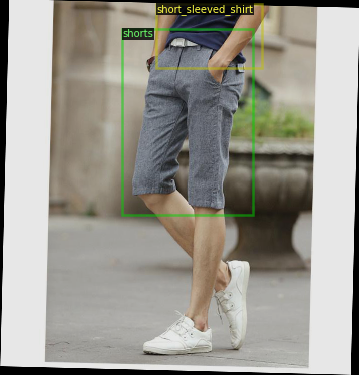

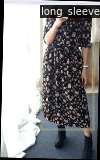

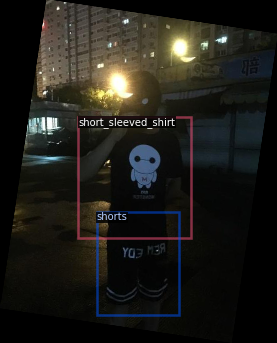

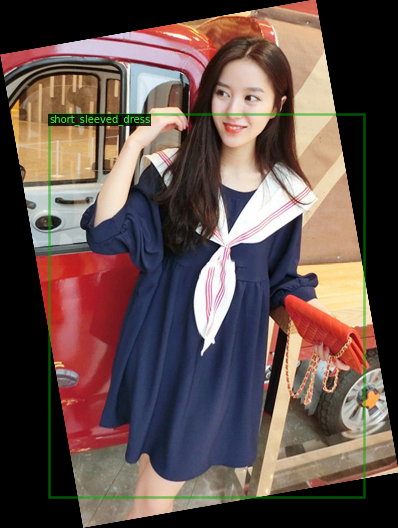

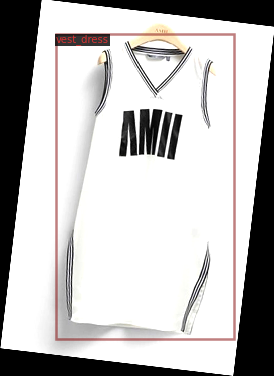

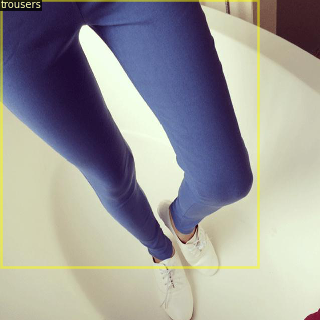

In [11]:
from itertools import islice
from detectron2.data import detection_utils as utils

def display_data_loader_img(img):
    img = utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)
        
    visualizer = Visualizer(img, metadata=clothes_metadata, scale=0.5)

    target_fields = record["instances"].get_fields()
    class_names = [clothes_metadata.thing_classes[x] for x in target_fields.get("gt_classes", None)]

    out = visualizer.overlay_instances(
        labels = class_names,
        boxes=target_fields.get("gt_boxes", None),
    )

    img_pil = Image.fromarray(out.get_image(), 'RGB')
    display(img_pil)

for batch in islice(augmentation_data_loader, 0, 10):
    for _, record in enumerate(batch[:2]):
        img_augmented = record['image'].permute(1,2,0)
        display_data_loader_img(img_augmented)

### training

In [12]:
trainer.resume_or_load(resume=True)
trainer.train()

[06/27 15:51:25 d2.engine.train_loop]: Starting training from iteration 270000
[06/27 15:51:37 d2.utils.events]:  eta: 1:06:01  iter: 270019  total_loss: 0.09226  loss_cls: 0.04101  loss_box_reg: 0.04403  loss_rpn_cls: 9.513e-05  loss_rpn_loc: 0.002603  time: 0.4613  data_time: 0.0983  lr: 1e-05  max_mem: 4702M
[06/27 15:51:48 d2.utils.events]:  eta: 1:23:11  iter: 270039  total_loss: 0.1048  loss_cls: 0.05583  loss_box_reg: 0.05258  loss_rpn_cls: 6.562e-05  loss_rpn_loc: 0.002831  time: 0.5221  data_time: 0.0037  lr: 1e-05  max_mem: 4702M
[06/27 15:51:59 d2.utils.events]:  eta: 1:24:51  iter: 270059  total_loss: 0.1014  loss_cls: 0.04026  loss_box_reg: 0.0474  loss_rpn_cls: 0.0001795  loss_rpn_loc: 0.002249  time: 0.5290  data_time: 0.0035  lr: 1e-05  max_mem: 4702M
[06/27 15:52:10 d2.utils.events]:  eta: 1:24:40  iter: 270079  total_loss: 0.1087  loss_cls: 0.05106  loss_box_reg: 0.06075  loss_rpn_cls: 6.466e-05  loss_rpn_loc: 0.003455  time: 0.5285  data_time: 0.0037  lr: 1e-05  max_

[06/27 15:57:43 d2.utils.events]:  eta: 1:18:43  iter: 270699  total_loss: 0.09147  loss_cls: 0.02917  loss_box_reg: 0.05419  loss_rpn_cls: 0.0001982  loss_rpn_loc: 0.003613  time: 0.5355  data_time: 0.0039  lr: 1e-05  max_mem: 5080M
[06/27 15:57:55 d2.utils.events]:  eta: 1:18:41  iter: 270719  total_loss: 0.09476  loss_cls: 0.03919  loss_box_reg: 0.04121  loss_rpn_cls: 6.245e-05  loss_rpn_loc: 0.002951  time: 0.5365  data_time: 0.0039  lr: 1e-05  max_mem: 5080M
[06/27 15:58:05 d2.utils.events]:  eta: 1:18:31  iter: 270739  total_loss: 0.1025  loss_cls: 0.0408  loss_box_reg: 0.05346  loss_rpn_cls: 7.279e-05  loss_rpn_loc: 0.00267  time: 0.5365  data_time: 0.0037  lr: 1e-05  max_mem: 5080M
[06/27 15:58:16 d2.utils.events]:  eta: 1:18:24  iter: 270759  total_loss: 0.08784  loss_cls: 0.04473  loss_box_reg: 0.03959  loss_rpn_cls: 0.0003005  loss_rpn_loc: 0.002464  time: 0.5368  data_time: 0.0038  lr: 1e-05  max_mem: 5080M
[06/27 15:58:27 d2.utils.events]:  eta: 1:18:14  iter: 270779  tota

[06/27 16:03:50 d2.utils.events]:  eta: 1:14:52  iter: 271379  total_loss: 0.0782  loss_cls: 0.03319  loss_box_reg: 0.0349  loss_rpn_cls: 7.349e-05  loss_rpn_loc: 0.002592  time: 0.5368  data_time: 0.0037  lr: 1e-05  max_mem: 5080M
[06/27 16:04:01 d2.utils.events]:  eta: 1:14:42  iter: 271399  total_loss: 0.09331  loss_cls: 0.03945  loss_box_reg: 0.04872  loss_rpn_cls: 6.677e-05  loss_rpn_loc: 0.00265  time: 0.5371  data_time: 0.0039  lr: 1e-05  max_mem: 5080M
[06/27 16:04:11 d2.utils.events]:  eta: 1:14:19  iter: 271419  total_loss: 0.1101  loss_cls: 0.05237  loss_box_reg: 0.04655  loss_rpn_cls: 0.0001494  loss_rpn_loc: 0.00278  time: 0.5366  data_time: 0.0037  lr: 1e-05  max_mem: 5080M
[06/27 16:04:22 d2.utils.events]:  eta: 1:14:03  iter: 271439  total_loss: 0.1019  loss_cls: 0.04349  loss_box_reg: 0.04704  loss_rpn_cls: 0.000302  loss_rpn_loc: 0.003115  time: 0.5366  data_time: 0.0038  lr: 1e-05  max_mem: 5080M
[06/27 16:04:33 d2.utils.events]:  eta: 1:13:48  iter: 271459  total_lo

[06/27 16:09:57 d2.utils.events]:  eta: 1:07:35  iter: 272059  total_loss: 0.1117  loss_cls: 0.05037  loss_box_reg: 0.05389  loss_rpn_cls: 0.0001496  loss_rpn_loc: 0.004002  time: 0.5377  data_time: 0.0038  lr: 1e-05  max_mem: 5080M
[06/27 16:10:08 d2.utils.events]:  eta: 1:07:21  iter: 272079  total_loss: 0.1081  loss_cls: 0.03877  loss_box_reg: 0.05246  loss_rpn_cls: 0.00012  loss_rpn_loc: 0.002517  time: 0.5376  data_time: 0.0039  lr: 1e-05  max_mem: 5080M
[06/27 16:10:19 d2.utils.events]:  eta: 1:07:16  iter: 272099  total_loss: 0.1113  loss_cls: 0.0466  loss_box_reg: 0.06139  loss_rpn_cls: 0.0002045  loss_rpn_loc: 0.002991  time: 0.5377  data_time: 0.0037  lr: 1e-05  max_mem: 5080M
[06/27 16:10:30 d2.utils.events]:  eta: 1:07:11  iter: 272119  total_loss: 0.1176  loss_cls: 0.06088  loss_box_reg: 0.0498  loss_rpn_cls: 9.792e-05  loss_rpn_loc: 0.004114  time: 0.5377  data_time: 0.0037  lr: 1e-05  max_mem: 5080M
[06/27 16:10:40 d2.utils.events]:  eta: 1:06:58  iter: 272139  total_los

[06/27 16:16:08 d2.utils.events]:  eta: 1:02:00  iter: 272739  total_loss: 0.09286  loss_cls: 0.04181  loss_box_reg: 0.05152  loss_rpn_cls: 9.103e-05  loss_rpn_loc: 0.002532  time: 0.5394  data_time: 0.0038  lr: 1e-05  max_mem: 5080M
[06/27 16:16:20 d2.utils.events]:  eta: 1:01:59  iter: 272759  total_loss: 0.09661  loss_cls: 0.04097  loss_box_reg: 0.05311  loss_rpn_cls: 0.000108  loss_rpn_loc: 0.00306  time: 0.5396  data_time: 0.0040  lr: 1e-05  max_mem: 5080M
[06/27 16:16:30 d2.utils.events]:  eta: 1:01:35  iter: 272779  total_loss: 0.09673  loss_cls: 0.04218  loss_box_reg: 0.05485  loss_rpn_cls: 0.0002464  loss_rpn_loc: 0.004662  time: 0.5394  data_time: 0.0037  lr: 1e-05  max_mem: 5080M
[06/27 16:16:40 d2.utils.events]:  eta: 1:01:18  iter: 272799  total_loss: 0.08069  loss_cls: 0.0361  loss_box_reg: 0.03551  loss_rpn_cls: 7.408e-05  loss_rpn_loc: 0.00281  time: 0.5391  data_time: 0.0036  lr: 1e-05  max_mem: 5080M
[06/27 16:16:50 d2.utils.events]:  eta: 1:01:04  iter: 272819  total

[06/27 16:22:19 d2.utils.events]:  eta: 0:55:46  iter: 273419  total_loss: 0.0927  loss_cls: 0.03368  loss_box_reg: 0.04927  loss_rpn_cls: 7.17e-05  loss_rpn_loc: 0.002592  time: 0.5404  data_time: 0.0037  lr: 1e-05  max_mem: 5096M
[06/27 16:22:31 d2.utils.events]:  eta: 0:55:38  iter: 273439  total_loss: 0.08939  loss_cls: 0.03444  loss_box_reg: 0.04851  loss_rpn_cls: 0.0001083  loss_rpn_loc: 0.002473  time: 0.5405  data_time: 0.0039  lr: 1e-05  max_mem: 5096M
[06/27 16:22:41 d2.utils.events]:  eta: 0:55:30  iter: 273459  total_loss: 0.13  loss_cls: 0.06884  loss_box_reg: 0.05035  loss_rpn_cls: 0.0001006  loss_rpn_loc: 0.003282  time: 0.5404  data_time: 0.0039  lr: 1e-05  max_mem: 5096M
[06/27 16:22:52 d2.utils.events]:  eta: 0:55:17  iter: 273479  total_loss: 0.08857  loss_cls: 0.04091  loss_box_reg: 0.0454  loss_rpn_cls: 6.309e-05  loss_rpn_loc: 0.003224  time: 0.5404  data_time: 0.0041  lr: 1e-05  max_mem: 5096M
[06/27 16:23:04 d2.utils.events]:  eta: 0:55:06  iter: 273499  total_l

[06/27 16:28:26 d2.utils.events]:  eta: 0:50:38  iter: 274099  total_loss: 0.09206  loss_cls: 0.04328  loss_box_reg: 0.04351  loss_rpn_cls: 0.0001001  loss_rpn_loc: 0.002835  time: 0.5400  data_time: 0.0042  lr: 1e-05  max_mem: 5096M
[06/27 16:28:36 d2.utils.events]:  eta: 0:50:21  iter: 274119  total_loss: 0.1013  loss_cls: 0.03785  loss_box_reg: 0.05272  loss_rpn_cls: 0.0001836  loss_rpn_loc: 0.003488  time: 0.5397  data_time: 0.0038  lr: 1e-05  max_mem: 5096M
[06/27 16:28:47 d2.utils.events]:  eta: 0:50:11  iter: 274139  total_loss: 0.08896  loss_cls: 0.04323  loss_box_reg: 0.03647  loss_rpn_cls: 0.0001139  loss_rpn_loc: 0.00248  time: 0.5399  data_time: 0.0038  lr: 1e-05  max_mem: 5096M
[06/27 16:28:58 d2.utils.events]:  eta: 0:49:59  iter: 274159  total_loss: 0.09568  loss_cls: 0.04613  loss_box_reg: 0.0481  loss_rpn_cls: 0.0001311  loss_rpn_loc: 0.003282  time: 0.5398  data_time: 0.0037  lr: 1e-05  max_mem: 5096M
[06/27 16:29:08 d2.utils.events]:  eta: 0:49:44  iter: 274179  tota

[06/27 16:34:28 d2.utils.events]:  eta: 0:44:10  iter: 274779  total_loss: 0.07715  loss_cls: 0.03503  loss_box_reg: 0.03819  loss_rpn_cls: 8.847e-05  loss_rpn_loc: 0.002537  time: 0.5388  data_time: 0.0040  lr: 1e-05  max_mem: 5096M
[06/27 16:34:39 d2.utils.events]:  eta: 0:43:57  iter: 274799  total_loss: 0.1187  loss_cls: 0.05046  loss_box_reg: 0.06152  loss_rpn_cls: 0.000115  loss_rpn_loc: 0.003704  time: 0.5388  data_time: 0.0036  lr: 1e-05  max_mem: 5096M
[06/27 16:34:50 d2.utils.events]:  eta: 0:43:48  iter: 274819  total_loss: 0.1381  loss_cls: 0.05245  loss_box_reg: 0.06761  loss_rpn_cls: 0.0001247  loss_rpn_loc: 0.004294  time: 0.5389  data_time: 0.0037  lr: 1e-05  max_mem: 5096M
[06/27 16:35:01 d2.utils.events]:  eta: 0:43:38  iter: 274839  total_loss: 0.1259  loss_cls: 0.04559  loss_box_reg: 0.06305  loss_rpn_cls: 9.642e-05  loss_rpn_loc: 0.00327  time: 0.5389  data_time: 0.0038  lr: 1e-05  max_mem: 5096M
[06/27 16:35:11 d2.utils.events]:  eta: 0:43:23  iter: 274859  total_

[06/27 16:40:37 d2.utils.events]:  eta: 0:38:35  iter: 275459  total_loss: 0.1203  loss_cls: 0.058  loss_box_reg: 0.04789  loss_rpn_cls: 0.0001025  loss_rpn_loc: 0.002888  time: 0.5392  data_time: 0.0035  lr: 1e-05  max_mem: 5096M
[06/27 16:40:48 d2.utils.events]:  eta: 0:38:24  iter: 275479  total_loss: 0.1121  loss_cls: 0.04783  loss_box_reg: 0.06113  loss_rpn_cls: 8.031e-05  loss_rpn_loc: 0.003343  time: 0.5391  data_time: 0.0041  lr: 1e-05  max_mem: 5096M
[06/27 16:40:59 d2.utils.events]:  eta: 0:38:17  iter: 275499  total_loss: 0.09218  loss_cls: 0.03546  loss_box_reg: 0.04858  loss_rpn_cls: 0.0001142  loss_rpn_loc: 0.003054  time: 0.5392  data_time: 0.0038  lr: 1e-05  max_mem: 5096M
[06/27 16:41:10 d2.utils.events]:  eta: 0:38:06  iter: 275519  total_loss: 0.09951  loss_cls: 0.03572  loss_box_reg: 0.04804  loss_rpn_cls: 0.0001262  loss_rpn_loc: 0.002272  time: 0.5391  data_time: 0.0036  lr: 1e-05  max_mem: 5096M
[06/27 16:41:20 d2.utils.events]:  eta: 0:37:56  iter: 275539  total

[06/27 16:46:46 d2.utils.events]:  eta: 0:33:13  iter: 276139  total_loss: 0.1115  loss_cls: 0.048  loss_box_reg: 0.06278  loss_rpn_cls: 7.658e-05  loss_rpn_loc: 0.002796  time: 0.5393  data_time: 0.0037  lr: 1e-05  max_mem: 5096M
[06/27 16:46:58 d2.utils.events]:  eta: 0:33:06  iter: 276159  total_loss: 0.1106  loss_cls: 0.04915  loss_box_reg: 0.05255  loss_rpn_cls: 0.0001217  loss_rpn_loc: 0.002662  time: 0.5395  data_time: 0.0038  lr: 1e-05  max_mem: 5096M
[06/27 16:47:10 d2.utils.events]:  eta: 0:33:00  iter: 276179  total_loss: 0.0881  loss_cls: 0.0367  loss_box_reg: 0.05059  loss_rpn_cls: 7.866e-05  loss_rpn_loc: 0.003016  time: 0.5397  data_time: 0.0040  lr: 1e-05  max_mem: 5096M
[06/27 16:47:21 d2.utils.events]:  eta: 0:32:52  iter: 276199  total_loss: 0.09338  loss_cls: 0.04198  loss_box_reg: 0.0493  loss_rpn_cls: 6.683e-05  loss_rpn_loc: 0.002152  time: 0.5398  data_time: 0.0038  lr: 1e-05  max_mem: 5096M
[06/27 16:47:32 d2.utils.events]:  eta: 0:32:44  iter: 276219  total_lo

[06/27 16:52:57 d2.utils.events]:  eta: 0:27:08  iter: 276819  total_loss: 0.1179  loss_cls: 0.04915  loss_box_reg: 0.05868  loss_rpn_cls: 0.0001224  loss_rpn_loc: 0.003282  time: 0.5399  data_time: 0.0035  lr: 1e-05  max_mem: 5125M
[06/27 16:53:08 d2.utils.events]:  eta: 0:26:57  iter: 276839  total_loss: 0.1263  loss_cls: 0.04986  loss_box_reg: 0.06159  loss_rpn_cls: 0.0001463  loss_rpn_loc: 0.002469  time: 0.5399  data_time: 0.0038  lr: 1e-05  max_mem: 5125M
[06/27 16:53:19 d2.utils.events]:  eta: 0:26:48  iter: 276859  total_loss: 0.1  loss_cls: 0.05836  loss_box_reg: 0.04859  loss_rpn_cls: 0.00013  loss_rpn_loc: 0.002607  time: 0.5399  data_time: 0.0038  lr: 1e-05  max_mem: 5125M
[06/27 16:53:31 d2.utils.events]:  eta: 0:26:37  iter: 276879  total_loss: 0.07419  loss_cls: 0.02519  loss_box_reg: 0.03931  loss_rpn_cls: 6.368e-05  loss_rpn_loc: 0.002408  time: 0.5401  data_time: 0.0036  lr: 1e-05  max_mem: 5125M
[06/27 16:53:41 d2.utils.events]:  eta: 0:26:25  iter: 276899  total_los

[06/27 16:59:06 d2.utils.events]:  eta: 0:21:20  iter: 277499  total_loss: 0.08992  loss_cls: 0.02902  loss_box_reg: 0.04197  loss_rpn_cls: 0.0001306  loss_rpn_loc: 0.002365  time: 0.5401  data_time: 0.0040  lr: 1e-05  max_mem: 5125M
[06/27 16:59:18 d2.utils.events]:  eta: 0:21:10  iter: 277519  total_loss: 0.1115  loss_cls: 0.04371  loss_box_reg: 0.0615  loss_rpn_cls: 0.0001177  loss_rpn_loc: 0.003405  time: 0.5402  data_time: 0.0039  lr: 1e-05  max_mem: 5125M
[06/27 16:59:29 d2.utils.events]:  eta: 0:20:59  iter: 277539  total_loss: 0.1069  loss_cls: 0.05099  loss_box_reg: 0.05514  loss_rpn_cls: 0.0001703  loss_rpn_loc: 0.003607  time: 0.5402  data_time: 0.0040  lr: 1e-05  max_mem: 5125M
[06/27 16:59:40 d2.utils.events]:  eta: 0:20:49  iter: 277559  total_loss: 0.118  loss_cls: 0.04233  loss_box_reg: 0.06445  loss_rpn_cls: 8.503e-05  loss_rpn_loc: 0.002576  time: 0.5402  data_time: 0.0039  lr: 1e-05  max_mem: 5125M
[06/27 16:59:49 d2.utils.events]:  eta: 0:20:38  iter: 277579  total_

[06/27 17:05:15 d2.utils.events]:  eta: 0:15:33  iter: 278179  total_loss: 0.0914  loss_cls: 0.04311  loss_box_reg: 0.04436  loss_rpn_cls: 0.0002071  loss_rpn_loc: 0.002815  time: 0.5402  data_time: 0.0038  lr: 1e-05  max_mem: 5125M
[06/27 17:05:30 d2.utils.events]:  eta: 0:15:25  iter: 278199  total_loss: 0.09844  loss_cls: 0.04464  loss_box_reg: 0.05056  loss_rpn_cls: 5.025e-05  loss_rpn_loc: 0.002633  time: 0.5406  data_time: 0.0041  lr: 1e-05  max_mem: 5125M
[06/27 17:05:40 d2.utils.events]:  eta: 0:15:15  iter: 278219  total_loss: 0.1146  loss_cls: 0.05442  loss_box_reg: 0.0501  loss_rpn_cls: 0.0002265  loss_rpn_loc: 0.002211  time: 0.5406  data_time: 0.0040  lr: 1e-05  max_mem: 5125M
[06/27 17:05:52 d2.utils.events]:  eta: 0:15:05  iter: 278239  total_loss: 0.1071  loss_cls: 0.05134  loss_box_reg: 0.05201  loss_rpn_cls: 0.0001372  loss_rpn_loc: 0.003369  time: 0.5407  data_time: 0.0038  lr: 1e-05  max_mem: 5125M
[06/27 17:06:04 d2.utils.events]:  eta: 0:14:59  iter: 278259  total

[06/27 17:11:27 d2.utils.events]:  eta: 0:09:49  iter: 278859  total_loss: 0.0943  loss_cls: 0.03696  loss_box_reg: 0.04731  loss_rpn_cls: 0.0001135  loss_rpn_loc: 0.002605  time: 0.5406  data_time: 0.0040  lr: 1e-05  max_mem: 5125M
[06/27 17:11:39 d2.utils.events]:  eta: 0:09:39  iter: 278879  total_loss: 0.08621  loss_cls: 0.04234  loss_box_reg: 0.05301  loss_rpn_cls: 0.000146  loss_rpn_loc: 0.002367  time: 0.5407  data_time: 0.0034  lr: 1e-05  max_mem: 5125M
[06/27 17:11:50 d2.utils.events]:  eta: 0:09:29  iter: 278899  total_loss: 0.07347  loss_cls: 0.02861  loss_box_reg: 0.04067  loss_rpn_cls: 0.0001014  loss_rpn_loc: 0.003221  time: 0.5407  data_time: 0.0037  lr: 1e-05  max_mem: 5125M
[06/27 17:12:01 d2.utils.events]:  eta: 0:09:18  iter: 278919  total_loss: 0.1184  loss_cls: 0.04737  loss_box_reg: 0.05782  loss_rpn_cls: 0.0001623  loss_rpn_loc: 0.004704  time: 0.5408  data_time: 0.0040  lr: 1e-05  max_mem: 5125M
[06/27 17:12:13 d2.utils.events]:  eta: 0:09:08  iter: 278939  tota

[06/27 17:17:48 d2.utils.events]:  eta: 0:03:57  iter: 279539  total_loss: 0.092  loss_cls: 0.03212  loss_box_reg: 0.04637  loss_rpn_cls: 0.0001554  loss_rpn_loc: 0.003227  time: 0.5419  data_time: 0.0039  lr: 1e-05  max_mem: 5125M
[06/27 17:17:58 d2.utils.events]:  eta: 0:03:47  iter: 279559  total_loss: 0.1181  loss_cls: 0.05319  loss_box_reg: 0.05602  loss_rpn_cls: 7.178e-05  loss_rpn_loc: 0.002947  time: 0.5418  data_time: 0.0041  lr: 1e-05  max_mem: 5125M
[06/27 17:18:09 d2.utils.events]:  eta: 0:03:36  iter: 279579  total_loss: 0.1193  loss_cls: 0.05636  loss_box_reg: 0.04763  loss_rpn_cls: 0.0002874  loss_rpn_loc: 0.002794  time: 0.5418  data_time: 0.0037  lr: 1e-05  max_mem: 5125M
[06/27 17:18:20 d2.utils.events]:  eta: 0:03:26  iter: 279599  total_loss: 0.1047  loss_cls: 0.05487  loss_box_reg: 0.04942  loss_rpn_cls: 0.0002129  loss_rpn_loc: 0.002326  time: 0.5418  data_time: 0.0037  lr: 1e-05  max_mem: 5125M
[06/27 17:18:30 d2.utils.events]:  eta: 0:03:16  iter: 279619  total_

[06/27 17:23:36 d2.evaluation.evaluator]: Inference done 643/5000. 0.1351 s / img. ETA=0:09:54
[06/27 17:23:41 d2.evaluation.evaluator]: Inference done 680/5000. 0.1351 s / img. ETA=0:09:49
[06/27 17:23:46 d2.evaluation.evaluator]: Inference done 717/5000. 0.1352 s / img. ETA=0:09:44
[06/27 17:23:51 d2.evaluation.evaluator]: Inference done 753/5000. 0.1353 s / img. ETA=0:09:40
[06/27 17:23:56 d2.evaluation.evaluator]: Inference done 789/5000. 0.1355 s / img. ETA=0:09:36
[06/27 17:24:01 d2.evaluation.evaluator]: Inference done 826/5000. 0.1355 s / img. ETA=0:09:31
[06/27 17:24:06 d2.evaluation.evaluator]: Inference done 863/5000. 0.1356 s / img. ETA=0:09:26
[06/27 17:24:11 d2.evaluation.evaluator]: Inference done 900/5000. 0.1356 s / img. ETA=0:09:21
[06/27 17:24:16 d2.evaluation.evaluator]: Inference done 936/5000. 0.1357 s / img. ETA=0:09:17
[06/27 17:24:21 d2.evaluation.evaluator]: Inference done 973/5000. 0.1358 s / img. ETA=0:09:12
[06/27 17:24:26 d2.evaluation.evaluator]: Inferenc

[06/27 17:30:16 d2.evaluation.evaluator]: Inference done 3547/5000. 0.1363 s / img. ETA=0:03:20
[06/27 17:30:22 d2.evaluation.evaluator]: Inference done 3584/5000. 0.1363 s / img. ETA=0:03:15
[06/27 17:30:27 d2.evaluation.evaluator]: Inference done 3621/5000. 0.1363 s / img. ETA=0:03:09
[06/27 17:30:32 d2.evaluation.evaluator]: Inference done 3658/5000. 0.1363 s / img. ETA=0:03:04
[06/27 17:30:37 d2.evaluation.evaluator]: Inference done 3695/5000. 0.1363 s / img. ETA=0:02:59
[06/27 17:30:42 d2.evaluation.evaluator]: Inference done 3732/5000. 0.1363 s / img. ETA=0:02:54
[06/27 17:30:47 d2.evaluation.evaluator]: Inference done 3767/5000. 0.1363 s / img. ETA=0:02:49
[06/27 17:30:52 d2.evaluation.evaluator]: Inference done 3804/5000. 0.1364 s / img. ETA=0:02:44
[06/27 17:30:57 d2.evaluation.evaluator]: Inference done 3841/5000. 0.1363 s / img. ETA=0:02:39
[06/27 17:31:02 d2.evaluation.evaluator]: Inference done 3877/5000. 0.1364 s / img. ETA=0:02:34
[06/27 17:31:07 d2.evaluation.evaluator]

[06/27 17:44:51 d2.data.datasets.coco]: Loaded 5000 images in COCO format from ./dataset/detectron_annos/validation_annos_5000.json
[06/27 17:44:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/27 17:44:52 d2.data.common]: Serializing 5000 elements to byte tensors and concatenating them all ...
[06/27 17:44:53 d2.data.common]: Serialized dataset takes 65.75 MiB
WARNING [06/27 17:44:53 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[06/27 17:44:54 d2.evaluation.evaluator]: Start inference on 5000 images
[06/27 17:44:56 d2.evaluation.evaluator]: Inference done 11/5000. 0.1411 s / img. ETA=0:11:48
[06/27 17:45:02 d2.evaluation.evaluator]: Inference done 46/5000. 0.1433 s / img. ETA=0:11:56
[06/27 17:45:07 d2.evaluation.evaluator]: Inference done 83/5000. 0.1399 s / img. ET

[06/27 17:50:57 d2.evaluation.evaluator]: Inference done 2295/5000. 0.1563 s / img. ETA=0:07:07
[06/27 17:51:02 d2.evaluation.evaluator]: Inference done 2325/5000. 0.1565 s / img. ETA=0:07:02
[06/27 17:51:08 d2.evaluation.evaluator]: Inference done 2355/5000. 0.1567 s / img. ETA=0:06:58
[06/27 17:51:13 d2.evaluation.evaluator]: Inference done 2385/5000. 0.1568 s / img. ETA=0:06:54
[06/27 17:51:18 d2.evaluation.evaluator]: Inference done 2415/5000. 0.1569 s / img. ETA=0:06:49
[06/27 17:51:23 d2.evaluation.evaluator]: Inference done 2447/5000. 0.1569 s / img. ETA=0:06:44
[06/27 17:51:28 d2.evaluation.evaluator]: Inference done 2481/5000. 0.1568 s / img. ETA=0:06:38
[06/27 17:51:33 d2.evaluation.evaluator]: Inference done 2516/5000. 0.1566 s / img. ETA=0:06:32
[06/27 17:51:38 d2.evaluation.evaluator]: Inference done 2552/5000. 0.1564 s / img. ETA=0:06:26
[06/27 17:51:43 d2.evaluation.evaluator]: Inference done 2588/5000. 0.1561 s / img. ETA=0:06:20
[06/27 17:51:48 d2.evaluation.evaluator]

[06/27 17:57:39 d2.evaluation.evaluator]: Inference done 4731/5000. 0.1599 s / img. ETA=0:00:43
[06/27 17:57:44 d2.evaluation.evaluator]: Inference done 4760/5000. 0.1600 s / img. ETA=0:00:38
[06/27 17:57:49 d2.evaluation.evaluator]: Inference done 4789/5000. 0.1601 s / img. ETA=0:00:34
[06/27 17:57:54 d2.evaluation.evaluator]: Inference done 4818/5000. 0.1602 s / img. ETA=0:00:29
[06/27 17:57:59 d2.evaluation.evaluator]: Inference done 4846/5000. 0.1603 s / img. ETA=0:00:24
[06/27 17:58:04 d2.evaluation.evaluator]: Inference done 4874/5000. 0.1604 s / img. ETA=0:00:20
[06/27 17:58:09 d2.evaluation.evaluator]: Inference done 4904/5000. 0.1605 s / img. ETA=0:00:15
[06/27 17:58:14 d2.evaluation.evaluator]: Inference done 4933/5000. 0.1605 s / img. ETA=0:00:10
[06/27 17:58:20 d2.evaluation.evaluator]: Inference done 4963/5000. 0.1606 s / img. ETA=0:00:05
[06/27 17:58:25 d2.evaluation.evaluator]: Inference done 4992/5000. 0.1607 s / img. ETA=0:00:01
[06/27 17:58:27 d2.evaluation.evaluator]

## Inference & evaluation using trained model
Now, let's run inference with the trained model on the clothes validation dataset. First, let's create a predictor using the model we just trained:



Then, we randomly select several samples to visualize the prediction results.

In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [14]:
register_coco_instances("validation_all_dataset", {}, "./dataset/detectron_annos/validation_annos_all.json", "./dataset/validation/image")

[06/27 18:01:26 d2.data.datasets.coco]: Loading ./dataset/detectron_annos/validation_annos_all.json takes 11.04 seconds.
[06/27 18:01:27 d2.data.datasets.coco]: Loaded 32153 images in COCO format from ./dataset/detectron_annos/validation_annos_all.json


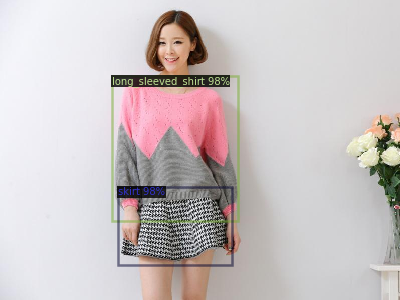

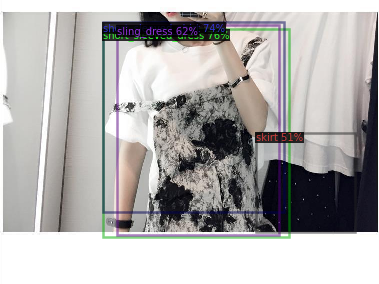

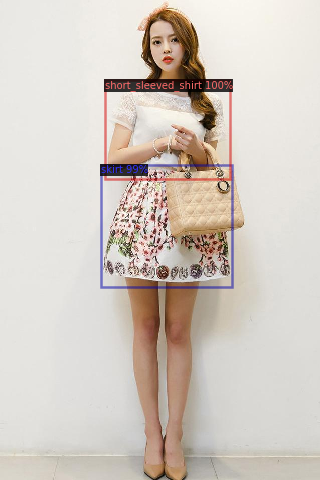

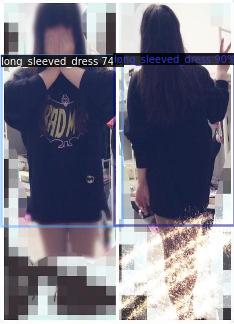

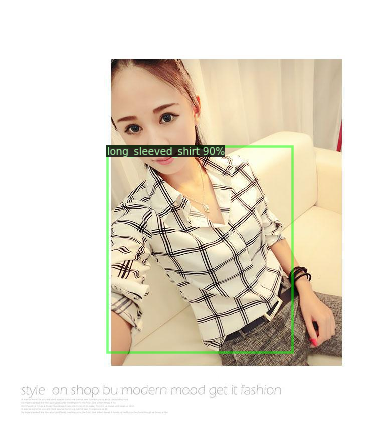

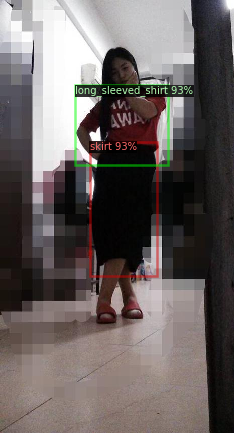

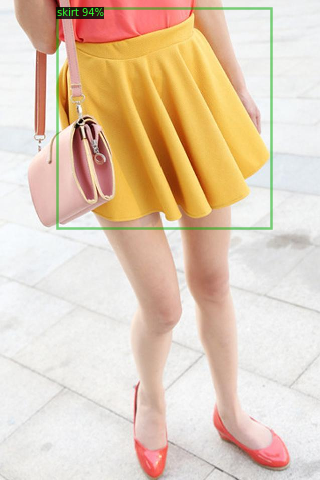

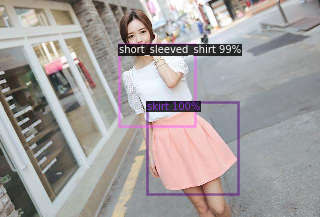

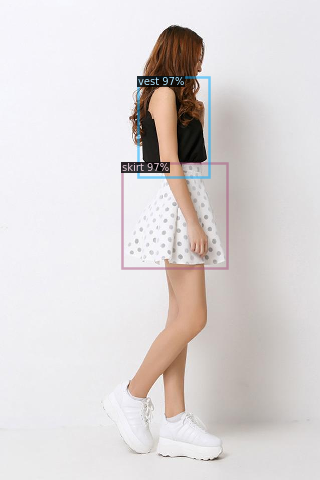

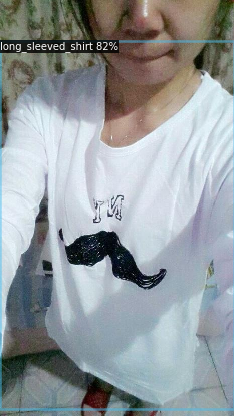

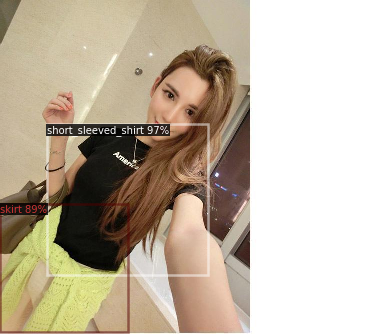

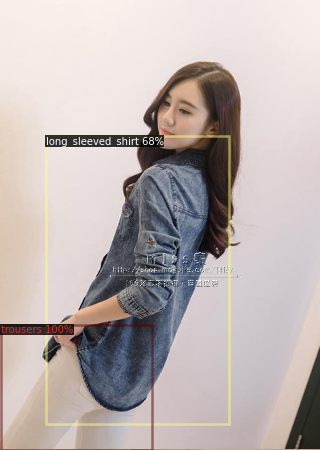

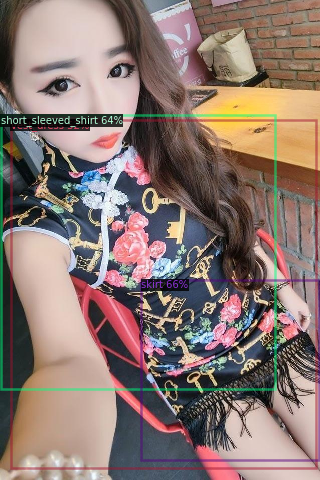

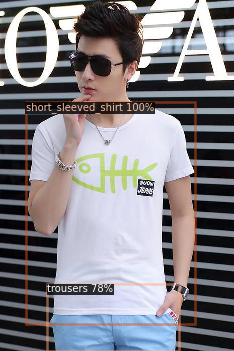

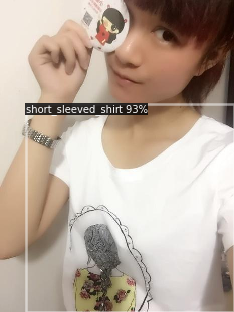

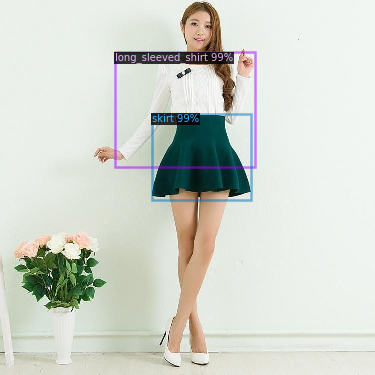

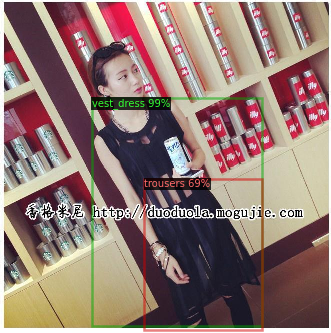

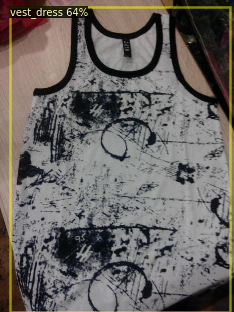

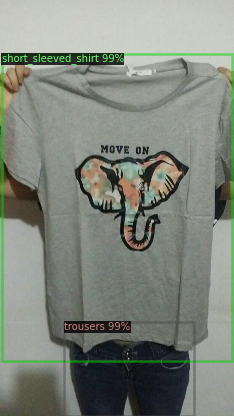

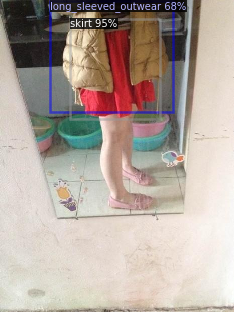

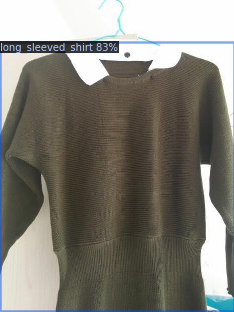

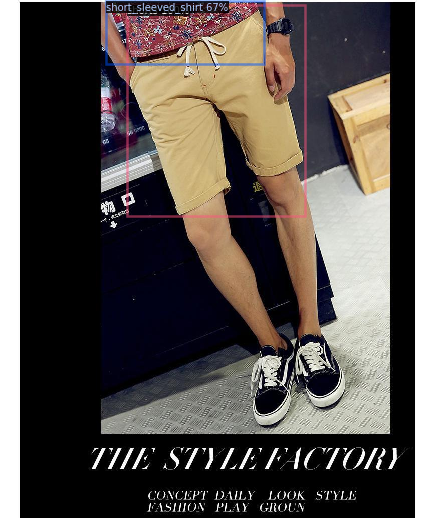

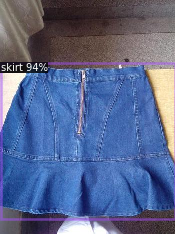

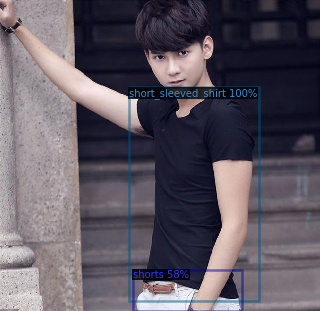

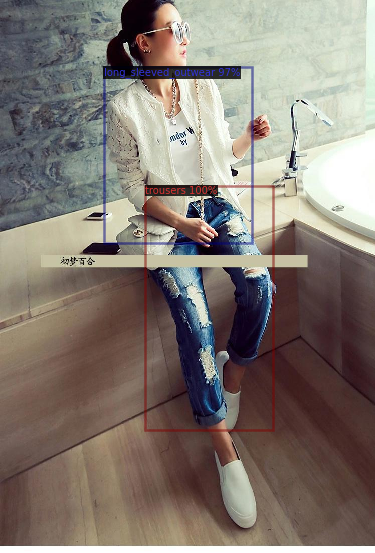

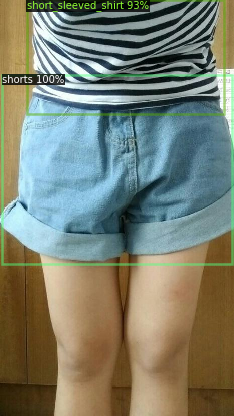

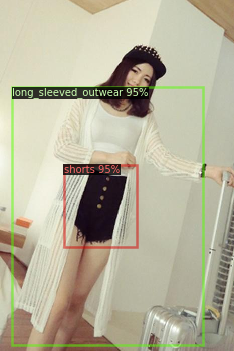

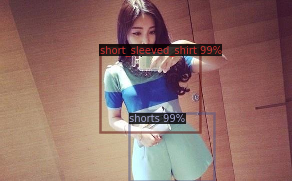

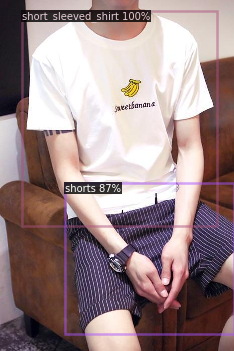

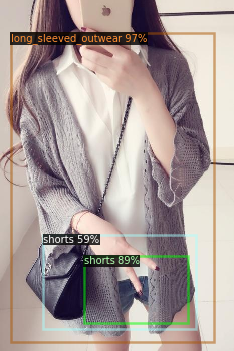

In [15]:

val_dataset_dicts = DatasetCatalog.get("validation_all_dataset")
for d in random.sample(val_dataset_dicts, 30):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=clothes_metadata, 
                   scale=0.5, 
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    img_pil = Image.fromarray(out.get_image(), 'RGB')
    display(img_pil)